In [14]:
import numpy as np
import sys
import os
import matplotlib.pylab as plt
import cv2
%matplotlib inline
import time

# caffe root 
caffe_root = '/usr/local/caffejuly2016/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe
#import PIL.Image
#from StringIO import StringIO

# configure plotting
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

print 'All libs were successfully loaded!'

All libs were successfully loaded!


In [2]:
###############################################################################
################################ functions ####################################
###############################################################################

# obtain input and output size of each layer
def find_iosizes(net1):
    io_size=[]
    for key in net1.blobs.keys():
        #print key
        temp=net1.blobs[key].shape[0],net1.blobs[key].shape[1],net1.blobs[key].shape[2],net1.blobs[key].shape[3]                        
        #print temp
        io_size=np.append(io_size,temp)
    # reshape         
    return np.reshape(io_size,(len(io_size)/4,4))

# obtain input and output size of each layer, except pooling layers
def find_iosizes2(net1):
    io_size=[]
    for key in net1.params.keys():
        #print key
        temp=net1.blobs[key].shape[0],net1.blobs[key].shape[1],net1.blobs[key].shape[2],net1.blobs[key].shape[3]                        
        #print temp
        io_size=np.append(io_size,temp)
    # reshape         
    return np.reshape(io_size,(len(io_size)/4,4))       


# obtain layer parameters: filter size, etc
def find_params(net1):
    w=[]
    b=[]
    layer_size=[]    
    for k in net1.params:
        for i,p in enumerate(net1.params[k]):
            #layer_size=p.data.shape
            tmp=(reduce(lambda x,y: x*y, p.data.shape))
            if i==0:            
                w=np.append(w,tmp)
                layer_size=np.append(layer_size,p.data.shape)
            if i==1:
                b=np.append(b,tmp)
            #print layer_size
    return w,b,layer_size
    

# read lmdb file
def read_lmdb(path2lmdb,ndim=0):
    print ('-'*50)
    print 'pleae wait while loading data ...'
    
    lmdb_env = lmdb.open(path2lmdb)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    datum = caffe.proto.caffe_pb2.Datum()

    # get the first data
    raw_datum = lmdb_txn.get(b'00000000')
    datum.ParseFromString(raw_datum)
    data = caffe.io.datum_to_array(datum)
   
    # define an empty array        
    X = np.empty((data.shape), 'uint8')
    for _, value in lmdb_cursor:
       datum.ParseFromString(value)
       data = caffe.io.datum_to_array(datum)
       X=np.append(X,data,axis=ndim)
    print ('-' *50)
    return X


# calcualte dice
def calc_dice(X,Y,dice_high=.7,dice_low=0.3,d=0):
    N=X.shape[d]    
    # intialize dice vector
    dice=np.zeros([N,1])

    for k in range(N):
        x=X[k,0] >.5 # convert to logical
        y =Y[k,0]>.5 # convert to logical

        # number of ones for intersection and union
        intersectXY=np.sum((x&y==1))
        unionXY=np.sum(x)+np.sum(y)

        if unionXY!=0:
            dice[k]=2* intersectXY/(unionXY*1.0)
            #print 'dice is: %0.2f' %dice[k]
        else:
            dice[k]=1
            #print 'dice is: %0.2f' % dice[k]
        #print 'processing %d, dice= %0.2f' %(k,dice[k])
    percent_high_dice=np.sum(dice>dice_high)/(N*1.0)            
    percent_low_dice=np.sum(dice<dice_low)/(N*1.0)            
    return np.mean(dice),dice,percent_high_dice,percent_low_dice
        

# stats
def stats_mask(Y):
    s1 = np.sum(np.sum(Y, axis=3), axis=2)  # sum over each mask
    nz1 = np.where(s1 > 0)  # find non zeros masks
    minA = np.min(s1[nz1])  # min area
    maxA=np.max(s1[nz1])    # max area
    meanA=np.mean(s1[nz1]) # average area

    return minA,maxA,meanA

# clean masks
def clean_mask(Y_pred,Y_true):
    # ground truth min area
    s1 = np.sum(np.sum(Y_true, axis=3), axis=2)  # sum over each mask
    nz1 = np.where(s1 > 0)  # find non zeros masks
    minarea = np.min(s1[nz1])  # min area
    maxarea=np.max(s1[nz1])    # max area
    meanarea=np.mean(s1[nz1]) # average area
    print 'min area: %3.2f, max area:,  and average area: ' % minarea, maxarea, meanarea

    # clean predictions
    s2 = np.sum(np.sum(Y_pred, axis=2), axis=2)  # sum over each mask
    nz2 = np.where(s2 > minarea)  # find indices greater than min area
    Y_clean=np.zeros(Y_true.shape,dtype='float32')
    Y_clean[nz2[0],:,:,:]=Y_pred[nz2[0],:,:,:]
    print 'masks were cleaned.'
    return Y_clean


def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))

def image_with_mask(img, mask,color=(1,0,0)):
    maximg=np.max(img)    
    if np.max(mask)==1:
        mask=mask*255
        mask=np.asarray(mask,dtype='uint8')
    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)<3:     
        img_color = grays_to_RGB(img)
    else:
        img_color=img
    if np.sum(mask)>0:    
        mask_edges = cv2.Canny(mask, 100, 200) > 0
    else:
        mask_edges=mask    
    #print np.sum(mask_edges)
    img_color[mask_edges, 0] = maximg*color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = maximg*color[1]
    img_color[mask_edges, 2] = maximg*color[2]
    
    img_color=img_color/float(np.max(img))
    return img_color

# sample
def disp_img_mask(img,mask):
    n1=np.random.randint(img.shape[0])
    I1=img[n1,0]
    M1=mask[n1,0]
    imgmask=image_with_mask(I1,M1)
    plt.imshow(imgmask)        


In [5]:
##############################################################################
##############################################################################
##############################################################################
           
# path to test data
path2testdata='../numpy/test.npz'
           
# path to model
model = '../net_deploy.prototxt'
if not os.path.isfile(model):
    print("Cannot find the model file!")

# path to weights
weights1 = '../trainedmodel/net_iter_46000.caffemodel'
if not os.path.isfile(weights1):
    print("Cannot find caffemodel!")
     
# set gpu mode and id
gpu_id=2
caffe.set_device(gpu_id)
caffe.set_mode_gpu()
#caffe.set_mode_cpu()
net1 = caffe.Net(model,weights1,caffe.TEST)    
#net1 = caffe.Net(model,caffe.TEST)    
print 'net was successfully created!'
#print("blobs {}\nparams {}".format(net1.blobs.keys(), net1.params.keys()))

# input& input of net layers
io_size=find_iosizes(net1) # with pooling layers
io_size2=find_iosizes2(net1) # without pooling layers

# parameters per layers
w,b,lsize=find_params(net1)

# keys    
lnames=net1.blobs.keys()
pnames=net1.params.keys()

total_ops=[]        
for k in range(0,len(w)-1):
    print ('-'*50)
    print 'Layer name: %s' %pnames[k]
    print 'Layer size: %s' %lsize[4*k:4*k+4]    
    print 'number of params:  %.1e' %w[k]    
    print 'IO_size: %s' %io_size2[k,:]
    ops_per_layer=w[k]*io_size2[k,2]*io_size2[k,3]    
    print 'Operations per layer:  %.1e' %(ops_per_layer)            
    total_ops=np.append(total_ops,ops_per_layer)
    print ('-'*50)

# summarize
print ('-'*50)
print 'Total parameters:  %.2e' %(np.sum(w)+np.sum(b))
print 'Total operations:  %.2e' %np.sum(total_ops)    

net was successfully created!
--------------------------------------------------
Layer name: conv1_1
Layer size: [ 64.   1.   5.   5.]
number of params:  1.6e+03
IO_size: [   1.   64.  288.  208.]
Operations per layer:  9.6e+07
--------------------------------------------------
--------------------------------------------------
Layer name: conv1_2
Layer size: [ 64.  64.   3.   3.]
number of params:  3.7e+04
IO_size: [   1.   64.  288.  208.]
Operations per layer:  2.2e+09
--------------------------------------------------
--------------------------------------------------
Layer name: conv2_1
Layer size: [ 128.   64.    3.    3.]
number of params:  7.4e+04
IO_size: [   1.  128.  144.  104.]
Operations per layer:  1.1e+09
--------------------------------------------------
--------------------------------------------------
Layer name: conv2_2
Layer size: [ 128.  128.    3.    3.]
number of params:  1.5e+05
IO_size: [   1.  128.  144.  104.]
Operations per layer:  2.2e+09
-----------------

--------------------------------------------------
wait to load test data ...
test data loaded!
images shape:  (5015, 1, 580, 420)
labels shape:  (5015, 1, 580, 420)
--------------------------------------------------


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8096f72810>,
 <matplotlib.text.Text at 0x7f8095a74250>)

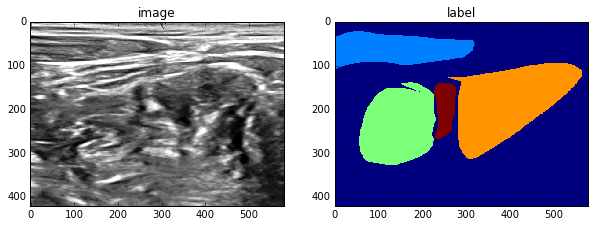

In [15]:
# load test data
print ('-'*50)
print 'wait to load test data ...'
tmp=np.load(path2testdata) 
X=tmp['X']
Y=tmp['Y']
print 'test data loaded!'
print 'images shape: ', X.shape
print 'labels shape: ', Y.shape
print ('-'*50)

# sample image and label
n1=np.random.randint(Y.shape[0])
x1=X[n1,0];x1=np.transpose(x1,(1,0))
y1=Y[n1,0];y1=np.transpose(y1,(1,0))
plt.subplot(121),plt.imshow(x1,cmap='Greys_r'),plt.title('image')
plt.subplot(122),plt.imshow(y1),plt.title('label')

In [8]:
# feed test data to the network 

# load test data
print ('-'*50)
print 'wait to load test data ...'
tmp=np.load(path2testdata) 
X=tmp['X']
Y=tmp['Y']
print 'test data loaded!'
print 'images shape: ', X.shape
print 'labels shape: ', Y.shape
print ('-'*50)

# feed test data ton the network and calculate Dice metric
# number of images 
N=X.shape[0]
# initialize Y_pred
Y_pred=np.zeros(Y.shape,dtype='uint8')
print ('-'*50)
print 'wait to perform forward operation ...'
start_time=time.time()
BS=59 # batch size
# loop over data
for k in range(0,N,BS):
    im=X[k:k+BS,:,:,:] # batch data
    im_input=im
    net1.blobs['data'].reshape(*im_input.shape)
    net1.blobs['data'].data[...] = im_input
    net1.forward()
    out = net1.blobs['prob'].data[...].argmax(axis=1)
    out=out[:,np.newaxis,:,:]
    Y_pred[k:k+BS,:,:,:]=out

print 'Forward operations completed!'
elapsed_time=time.time()-start_time
print 'Toral elapsed time: %d seconds' % elapsed_time
print 'Processing time per frame: %.1f ms' % (elapsed_time/N*1000)
print ('-'*50)

--------------------------------------------------
wait to load test data ...
test data loaded!
images shape:  (5015, 1, 580, 420)
labels shape:  (5015, 1, 580, 420)
--------------------------------------------------
--------------------------------------------------
wait to perform forward operation ...
Forward operations completed!
Toral elapsed time: 72 seconds
Processing time per frame: 14.5 ms
--------------------------------------------------


In [9]:
# caclulate dice metrics

# caclulate dice metrics
print ('-'*50)
print 'wait to calculate dice metrics'
avg_dice_scm,dice_scm,phighdice,plowdice=calc_dice(Y==1,Y_pred==1)
print 'Dice for SCM: %.2f ' %(avg_dice_scm)
print '%d percent have dice greater than 0.7' %(phighdice*100)
print '%d percent have dice lower than 0.3' %(plowdice*100)
print ('-'*20)

avg_dice_asm,dice_asm,phighdice,plowdice=calc_dice(Y==2,Y_pred==2)
print 'Dice for ASM: %.2f' %(avg_dice_asm)
print '%d percent have dice greater than 0.7' %(phighdice*100)
print '%d percent have dice lower than 0.3' %(plowdice*100)
print ('-'*20)

avg_dice_msm,dice_msm,phighdice,plowdice=calc_dice(Y==3,Y_pred==3)
print 'Dice for MSM: %.2f' %(avg_dice_msm)
print '%d percent have dice greater than 0.7' %(phighdice*100)
print '%d percent have dice lower than 0.3' %(plowdice*100)
print ('-'*20)

avg_dice_bp,dice_bp,phighdice,plowdice=calc_dice(Y==4,Y_pred==4)
print 'Dice for BP: %.2f' %(avg_dice_bp)
print '%d percent have dice greater than 0.7' %(phighdice*100)
print '%d percent have dice lower than 0.3' %(plowdice*100)

print ('-'*50)

--------------------------------------------------
wait to calculate dice metrics
Dice for SCM: 0.75 
78 percent have dice greater than 0.7
5 percent have dice lower than 0.3
--------------------
Dice for ASM: 0.74
73 percent have dice greater than 0.7
5 percent have dice lower than 0.3
--------------------
Dice for MSM: 0.68
63 percent have dice greater than 0.7
9 percent have dice lower than 0.3
--------------------
Dice for BP: 0.51
26 percent have dice greater than 0.7
21 percent have dice lower than 0.3
--------------------------------------------------


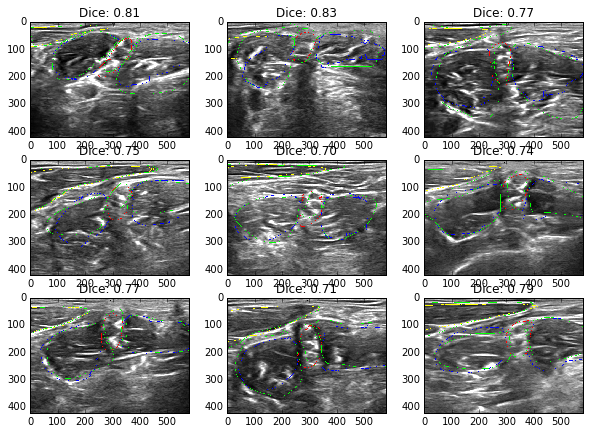

In [16]:
# sample images with predictions
nn=3
# finding index of images with high dice
ind_high=np.where(dice_bp>.7)
# picking random indices 
n1=np.random.randint(len(ind_high[0]),size=nn*nn)
n1=ind_high[0][n1]

for k2 in range(nn*nn):
    x1=X[n1[k2],0];x1=np.transpose(x1,(1,0)) # image
    y1=Y[n1[k2],0];y1=np.transpose(y1,(1,0)) # label
    y1p=Y_pred[n1[k2],0];y1p=np.transpose(y1p,(1,0)) # prediction

    imgmask=image_with_mask(x1,y1p==1,(1,1,0)) # add l1 to image
    imgmask=image_with_mask(imgmask,y1p==2,(0,0,1)) # add pred l2 to image
    imgmask=image_with_mask(imgmask,y1p==3,(0,0,1)) # add pred l3 to image
    imgmask=image_with_mask(imgmask,y1p==4,(1,0,0)) # add pred l4 to image
    imgmask=image_with_mask(imgmask,y1>0.5,(0,1,0)) # add label to image
    plt.subplot(nn,nn,k2+1),plt.imshow(imgmask),plt.title('Dice: %.2f'%dice_bp[n1[k2]])

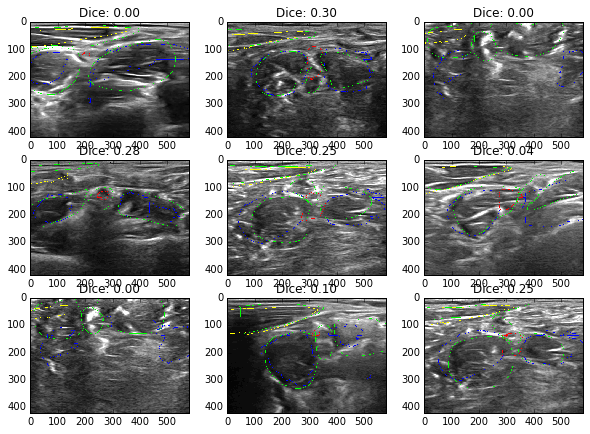

In [17]:
# finding index of images with low dice
ind_high=np.where(dice_bp<.3)
# picking random indices 
n1=np.random.randint(len(ind_high[0]),size=nn*nn)
n1=ind_high[0][n1]

for k2 in range(nn*nn):
    
    x1=X[n1[k2],0];x1=np.transpose(x1,(1,0)) # image
    y1=Y[n1[k2],0];y1=np.transpose(y1,(1,0)) # label
    y1p=Y_pred[n1[k2],0];y1p=np.transpose(y1p,(1,0)) # prediction

    imgmask=image_with_mask(x1,y1p==1,(1,1,0)) # add l1 to image
    imgmask=image_with_mask(imgmask,y1p==2,(0,0,1)) # add pred l2 to image
    imgmask=image_with_mask(imgmask,y1p==3,(0,0,1)) # add pred l3 to image
    imgmask=image_with_mask(imgmask,y1p==4,(1,0,0)) # add pred l4 to image
    imgmask=image_with_mask(imgmask,y1>0.5,(0,1,0)) # add label to image
    plt.subplot(nn,nn,k2+1),plt.imshow(imgmask),plt.title('Dice: %.2f'%dice_bp[n1[k2]])

In [13]:
# find min, max, average areas for manual and automatic contours

print ('-'*50)
print 'wait to obtain stats ...'
minA,maxA,meanA=stats_mask(Y)
print 'min, max, mean areas for manual contours : %.2e, %.2e, %.2e' % (minA, maxA, meanA)
minA,maxA,meanA=stats_mask(Y_pred)
print 'min, max, mean areas for automatic contours : %.2e, %.2e, %.2e' % (minA, maxA, meanA)
print ('-'*50)


--------------------------------------------------
wait to obtain stats ...
min, max, mean areas for manual contours : 4.15e+03, 4.43e+05, 1.80e+05
min, max, mean areas for automatic contours : 2.71e+04, 3.03e+05, 1.76e+05
--------------------------------------------------
